In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json

import torch
import torchvision
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

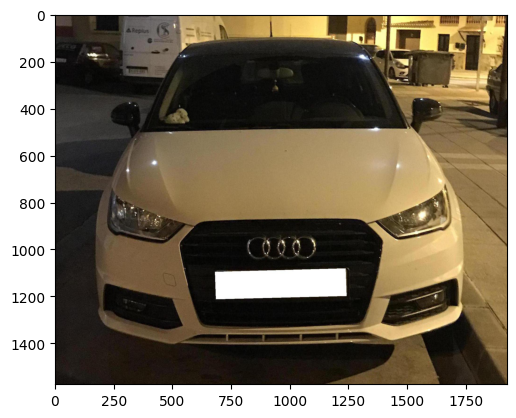

In [2]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./BD-461/Especificidad M/test/Audi/Audi_A1Sportback_2015-2018_5.jpg')
plt.imshow(img)

In [3]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [4]:
# TAMAÑO DE LAS IMÁGENES
IMG_SIZE = (256, 256)

# DIMENSIÓN DE LA CAPA DE TEMPLATES DE LOS lenet_model_trainedS
TEMPLATE_SIZE = 256

# Se establece el número de épocas
EPOCHS = 25

# Se establece el tamaño de batch
BATCH_SIZE = 64#32#64

# Se establece el learning rate inicial
LEARNING_RATE = 0.0005

# Directorio que contiene la base de datos sobre la que vamos a realizar el entrenamiento
MAIN_DIR ="./BD-461/Especificidad M/"

# Numero de clases a diferenciar en el clasificador
CLASES = 34

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, CLASES)
pesos = torch.load('./models/resnet50-EspecificidadM.pt',map_location='cuda')
model.load_state_dict(pesos)
#model.to(device)
model.eval()
#lenet_model_trained.eval()

Using cache found in /home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/andres/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [7]:
test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_dataset = torchvision.datasets.ImageFolder(
    root = MAIN_DIR + "test",
    transform=test_transform
    )

test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
idx2label = test_dataset.classes

In [8]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

In [9]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.9993123, 2, 'Audi'),
 (0.00025090668, 12, 'Hyundai'),
 (0.00015925663, 13, 'Infinity'),
 (3.6273996e-05, 4, 'Chevrolet'),
 (3.5041772e-05, 10, 'Ford'))

In [10]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [11]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [12]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

2

In [13]:
from lime import lime_image

/home/andres/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

100%|██████████| 1000/1000 [00:05<00:00, 177.34it/s]


Aqui podemos ver la explicación para la clase con mayor puntuación, variando explanation.top_labels[i] veremos la explicación de la iésima clase con mayor puntuación 

In [15]:
from skimage.segmentation import mark_boundaries

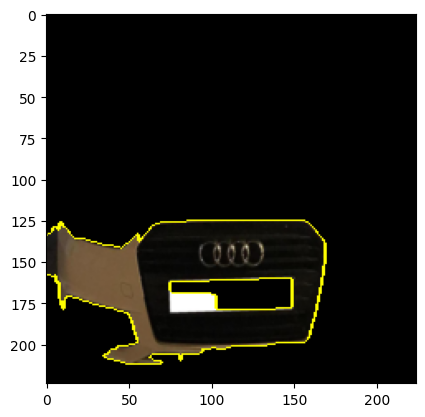

In [16]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp/255.0, mask))

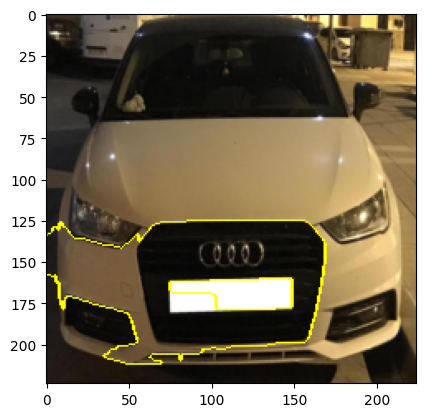

In [17]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

We can also see the 'pros and cons' (pros in green, cons in red)

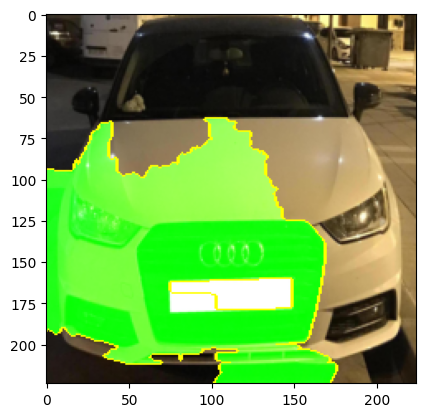

In [18]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

Or the pros and cons that have weight at least 0.1

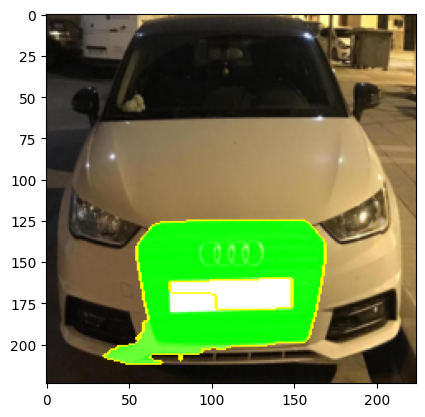

In [19]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp/255.0, mask))